## What Is The Effect Of The Earth's Temperature on Cyclonic Storms?

- https://berkeleyearth.org/data/
- https://svs.gsfc.nasa.gov/5450/
- https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01552
- https://www.spc.noaa.gov/wcm/#data

        - https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf

- https://www.ncei.noaa.gov/sites/g/files/anmtlf171/files/2025-04/IBTrACS_version4r01_Technical_Details.pdf
- https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf

> Basin - All storms that have at least one position in that basin. This allows analysis of a
given basin but also means that different basin files should not be combined since some
storms will be in both files.

>SID* A unique storm identifier (SID) assigned by IBTrACS algorithm

### Earth's Temperature

In [14]:
import pandas as pd
import numpy as np
import re

NH_PATH = "NH.Ts+dSST.csv"
SH_PATH = "SH.Ts+dSST.csv"

MONTHS = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
MONTH_NUM = {m:i+1 for i, m in enumerate(MONTHS)}

def read_and_long(path, hemisphere: str) -> pd.DataFrame:
    df = pd.read_csv(path, skip_blank_lines=True, header=1)
    # Standardize headers and drop auto Unnamed cols
    df.columns = [c.strip() for c in df.columns]
    df = df.loc[:, ~df.columns.str.match(r"^Unnamed")]

    # Find a year column, fallback to first column
    year_col = next((c for c in ["Year","year","YEAR","Date","date"] if c in df.columns), df.columns[0])

    # Map many header variants to Jan..Dec
    month_alias = {
        "JAN":"Jan","FEB":"Feb","MAR":"Mar","APR":"Apr","MAY":"May","JUN":"Jun",
        "JUL":"Jul","AUG":"Aug","SEP":"Sep","OCT":"Oct","NOV":"Nov","DEC":"Dec",
        "Jan":"Jan","Feb":"Feb","Mar":"Mar","Apr":"Apr","May":"May","Jun":"Jun",
        "Jul":"Jul","Aug":"Aug","Sep":"Sep","Oct":"Oct","Nov":"Nov","Dec":"Dec",
        "JAN.":"Jan","FEB.":"Feb","MAR.":"Mar","APR.":"Apr","MAY.":"May","JUN.":"Jun",
        "JUL.":"Jul","AUG.":"Aug","SEP.":"Sep","OCT.":"Oct","NOV.":"Nov","DEC.":"Dec",
    }

    rename = {}
    month_cols = []
    for c in df.columns:
        if c == year_col:
            continue
        token = re.sub(r"[^A-Za-z]", "", c)  # strip digits, dots, asterisks
        if token in month_alias:
            rename[c] = month_alias[token]
            month_cols.append(c)

    # If detection failed, fall back to literal Jan..Dec if present
    if not month_cols:
        for m in MONTHS:
            if m in df.columns:
                month_cols.append(m)
                rename[m] = m

    # Rename and keep only Year + months
    if rename:
        df = df.rename(columns=rename)
    keep = [year_col] + [m for m in MONTHS if m in df.columns]
    df = df[keep]

    # Numeric coercion
    df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
    for m in keep[1:]:
        df[m] = pd.to_numeric(df[m], errors="coerce")

    # Long format
    long_df = df.melt(id_vars=[year_col], var_name="month", value_name="temp")
    long_df = long_df.dropna(subset=[year_col, "month"]).copy()
    long_df["hemisphere"] = hemisphere

    # Build a month midpoint date
    year_int = long_df[year_col].apply(lambda x: int(np.floor(x)) if pd.notna(x) else np.nan)
    long_df["date"] = pd.to_datetime(
        {"year": year_int, "month": long_df["month"].map(MONTH_NUM), "day": 15},
        errors="coerce"
    )

    long_df = long_df.rename(columns={year_col: "year"})
    long_df = long_df.sort_values(["hemisphere", "year", "month"], kind="mergesort").reset_index(drop=True)
    return long_df[["hemisphere","year","month","date","temp"]]

# Build outputs
nh_long = read_and_long(NH_PATH, "NH")
sh_long = read_and_long(SH_PATH, "SH")
temperature_df = pd.concat([nh_long, sh_long], ignore_index=True)

In [39]:
temperature_df['temp_f'] = (temperature_df['temp'] * 9/5) + 32

temperature_df

,hemisphere,year,month,date,temp,fahrenheit,temp_f
0,NH,1880,Apr,1880-04-15,-0.31,31.442,31.442
1,NH,1880,Aug,1880-08-15,-0.28,31.496,31.496
2,NH,1880,Dec,1880-12-15,-0.41,31.262,31.262
3,NH,1880,Feb,1880-02-15,-0.52,31.064,31.064
4,NH,1880,Jan,1880-01-15,-0.37,31.334,31.334
...,...,...,...,...,...,...,...
3499,SH,2025,Mar,2025-03-15,0.88,33.584,33.584
3500,SH,2025,May,2025-05-15,0.94,33.692,33.692
3501,SH,2025,Nov,2025-11-15,NaN,NaN,NaN
3502,SH,2025,Oct,2025-10-15,NaN,NaN,NaN


Text(0.5, 1.0, 'Global Temperatures Have Risen Steadily in the Past 25 Years (2000–2024)')

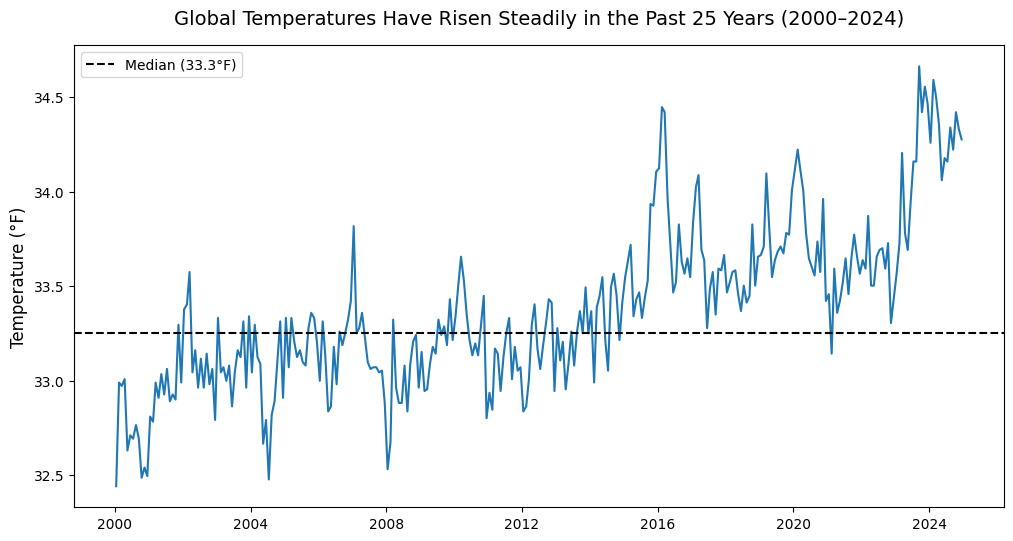

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
temperature_filtered = temperature_df[(temperature_df['year'] >= 2000) & (temperature_df['year'] <= 2024)]

median_temp = temperature_filtered['temp_f'].median()

plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=temperature_filtered, x='date', y='temp_f', errorbar=None)
ax.axhline(y=median_temp, color='black', linestyle='--', label=f'Median ({median_temp:.1f}°F)')

ax.legend()

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Temperature (°F)", fontsize=12)
ax.set_title("Global Temperatures Have Risen Steadily in the Past 25 Years (2000–2024)", fontsize=14, pad=15)

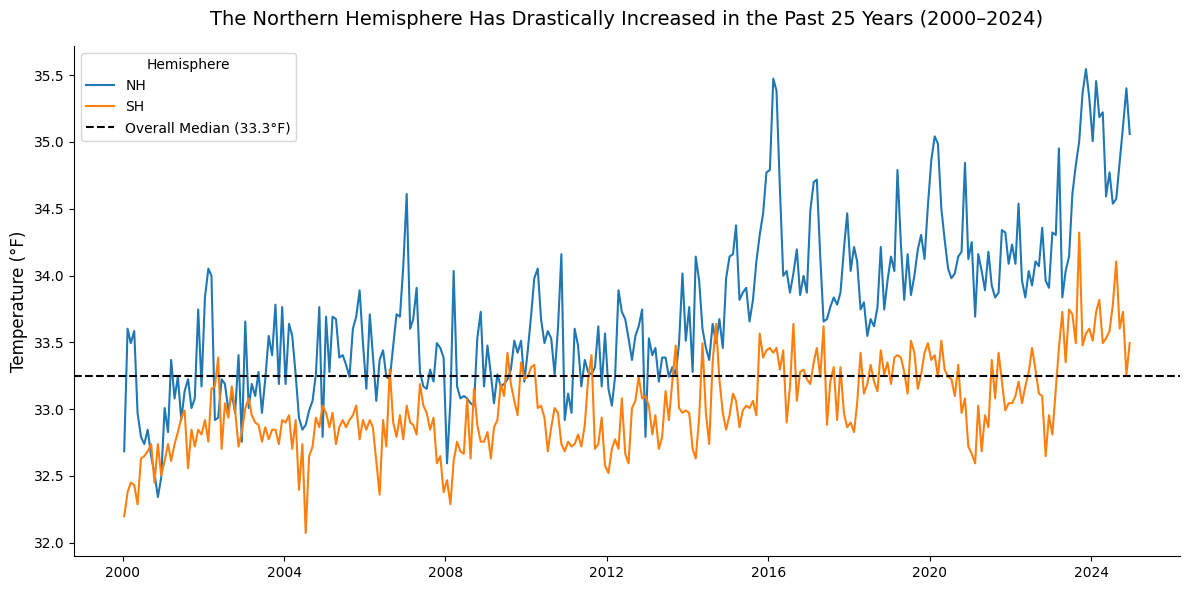

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    data=temperature_filtered,
    x='date',
    y='temp_f',
    hue='hemisphere',   # categorical column (e.g., 'NH' vs 'SH')
    errorbar=None
)

# Add median line (optional, can calculate separately if needed)
median_temp = temperature_filtered['temp_f'].median()
ax.axhline(y=median_temp, color='black', linestyle='--', label=f'Overall Median ({median_temp:.1f}°F)')

# Customize labels and title
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Temperature (°F)", fontsize=12)
ax.set_title("The Northern Hemisphere Has Drastically Increased in the Past 25 Years (2000–2024)", fontsize=14, pad=15)

# Show legend
ax.legend(title="Hemisphere")

sns.despine()
plt.tight_layout()
plt.show()

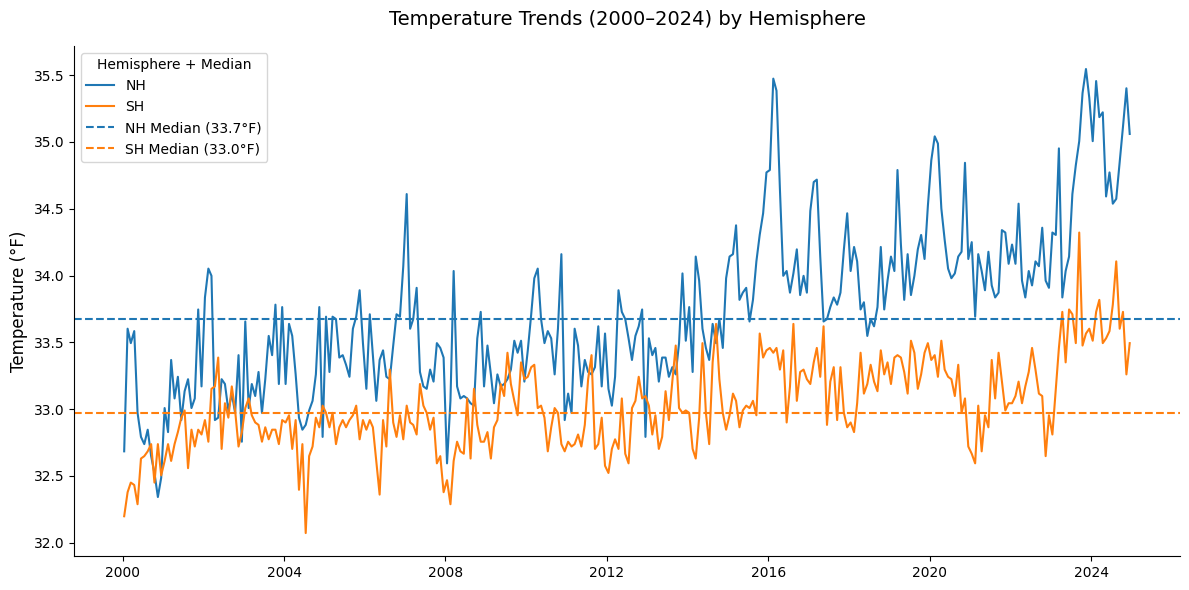

In [ ]:
plt.figure(figsize=(12, 6))

# Plot both hemispheres on the same graph
ax = sns.lineplot(
    data=temperature_filtered,
    x='date',
    y='temp_f',
    hue='hemisphere',
    errorbar=None
)

# Compute median per hemisphere
median_by_hemi = (
    temperature_filtered.groupby('hemisphere')['temp_f']
    .median()
    .to_dict()
)

# Add a horizontal line for each hemisphere median
colors = {'NH': 'tab:blue', 'SH': 'tab:orange'}  # adjust if your hue colors differ
for hemi, med in median_by_hemi.items():
    ax.axhline(
        y=med,
        color=colors.get(hemi, 'gray'),
        linestyle='--',
        linewidth=1.5,
        label=f"{hemi} Median ({med:.1f}°F)"
    )

# Customize labels and title
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Temperature (°F)", fontsize=12)
ax.set_title("Temperature Trends (2000–2024) by Hemisphere", fontsize=14, pad=15)

# Consolidate legend
ax.legend(title="Hemisphere + Median")

sns.despine()
plt.tight_layout()
plt.show()


### Hurricanes & Tropical Cyclones

In [78]:
df = pd.read_csv("noaa_hurricanes.csv")

# Helper to find likely column names regardless of exact casing/naming
def find_col(candidates, columns):
    lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand in lower:
            return lower[cand]
    for c in columns:
        lc = c.lower()
        if any(cand in lc for cand in candidates):
            return c
    return None

iso_col = find_col(["iso_time", "iso time", "isotime", "time_iso", "time"], df.columns)
lat_col = find_col(["latitude", "lat"], df.columns)
lon_col = find_col(["longitude", "lon", "lng"], df.columns)

if iso_col is None:
    raise ValueError("ISO time column not found")
if lat_col is None:
    raise ValueError("Latitude column not found")
if lon_col is None:
    raise ValueError("Longitude column not found")

# Parse to datetime
df["_parsed_dt"] = pd.to_datetime(df[iso_col], errors="coerce", utc=True)

# Snap each record to the 15th of its month
month_start = df["_parsed_dt"].dt.to_period("M").dt.to_timestamp()
df["month_15"] = month_start + pd.Timedelta(days=14)  # 1st + 14 days = 15th

df['year'] = df['month_15'].dt.year

# Hemisphere: NH for lat >= 0, SH for lat < 0
df["hemisphere"] = df[lat_col].apply(
    lambda x: "NH" if pd.notna(x) and float(x) >= 0 else ("SH" if pd.notna(x) else pd.NA)
)

hurricanes_df = df.copy()

/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_15841/1222042417.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  month_start = df["_parsed_dt"].dt.to_period("M").dt.to_timestamp()


Hurricanes = storms reaching ≥ Category 1 (≥74 mph)
Tropical Storms = weaker systems

In [85]:
hurricanes_only = hurricanes_df[hurricanes_df["usa_sshs"] >= 1]

In [89]:
hurricanes_only

,season,sid,basin,latitude,longitude,iso_time,usa_sshs,usa_wind,_parsed_dt,month_15,year,hemisphere
0,1989,1989053S15170,SP,-22.9753,172.7670,1989-02-28 09:00:00 UTC,1,82.0,1989-02-28 09:00:00+00:00,1989-02-15,1989,SH
1,1989,1989103N07154,WP,16.5200,150.5800,1989-04-22 00:00:00 UTC,4,130.0,1989-04-22 00:00:00+00:00,1989-04-15,1989,NH
2,1989,1989201N11145,WP,29.6668,133.3920,1989-07-27 03:00:00 UTC,2,87.0,1989-07-27 03:00:00+00:00,1989-07-15,1989,NH
3,1989,1989227N13261,EP,16.0437,-103.1400,1989-08-16 21:00:00 UTC,1,77.0,1989-08-16 21:00:00+00:00,1989-08-15,1989,NH
4,1989,1989230N14338,NaN,43.2822,-36.6972,1989-08-26 03:00:00 UTC,1,77.0,1989-08-26 03:00:00+00:00,1989-08-15,1989,NH
...,...,...,...,...,...,...,...,...,...,...,...,...
232429,2015,2015122N07144,WP,15.4000,124.5500,2015-05-09 12:00:00 UTC,4,120.0,2015-05-09 12:00:00+00:00,2015-05-15,2015,NH
232430,2015,2015180N09160,WP,26.1210,125.0830,2015-07-10 03:00:00 UTC,4,120.0,2015-07-10 03:00:00+00:00,2015-07-15,2015,NH
232431,2016,2016266N11144,WP,22.7164,123.7900,2016-09-26 21:00:00 UTC,4,120.0,2016-09-26 21:00:00+00:00,2016-09-15,2016,NH
232432,2016,2016269N15165,WP,22.2692,128.7430,2016-10-02 15:00:00 UTC,4,120.0,2016-10-02 15:00:00+00:00,2016-10-15,2016,NH


In [90]:
hurricanes_max = (
    hurricanes_only
    .sort_values('usa_sshs', ascending=False)   # sort so highest appears first
    .drop_duplicates(subset='sid', keep='first')  # keep only one per storm
)

hurricanes_max

,season,sid,basin,latitude,longitude,iso_time,usa_sshs,usa_wind,_parsed_dt,month_15,year,hemisphere
12079,1998,1998281N11151,WP,17.00000,122.7250,1998-10-14 00:00:00 UTC,5,155.0,1998-10-14 00:00:00+00:00,1998-10-15,1998,NH
1971,2014,2014209N12152,WP,15.39250,133.5130,2014-08-03 03:00:00 UTC,5,137.0,2014-08-03 03:00:00+00:00,2014-08-15,2014,NH
1969,2014,2014092S11159,SP,-13.00620,146.2270,2014-04-10 15:00:00 UTC,5,140.0,2014-04-10 15:00:00+00:00,2014-04-15,2014,SH
1968,2014,2013350S08099,SI,-15.23120,83.0075,2013-12-21 09:00:00 UTC,5,137.0,2013-12-21 09:00:00+00:00,2013-12-15,2013,SH
7364,2015,2015226N15164,WP,20.03500,150.8460,2015-08-19 15:00:00 UTC,5,137.0,2015-08-19 15:00:00+00:00,2015-08-15,2015,NH
...,...,...,...,...,...,...,...,...,...,...,...,...
198294,2013,2013228N23124,WP,24.84980,125.3140,2013-08-20 21:00:00 UTC,1,65.0,2013-08-20 21:00:00+00:00,2013-08-15,2013,NH
198284,2010,2010019S11123,SI,-14.30000,123.5000,2010-01-21 06:00:00 UTC,1,65.0,2010-01-21 06:00:00+00:00,2010-01-15,2010,SH
197819,2005,2004312S05085,SI,-10.90000,77.2667,2004-11-09 00:00:00 UTC,1,65.0,2004-11-09 00:00:00+00:00,2004-11-15,2004,SH
198006,1992,1992311N06107,NI,7.55494,78.5574,1992-11-13 03:00:00 UTC,1,65.0,1992-11-13 03:00:00+00:00,1992-11-15,1992,NH


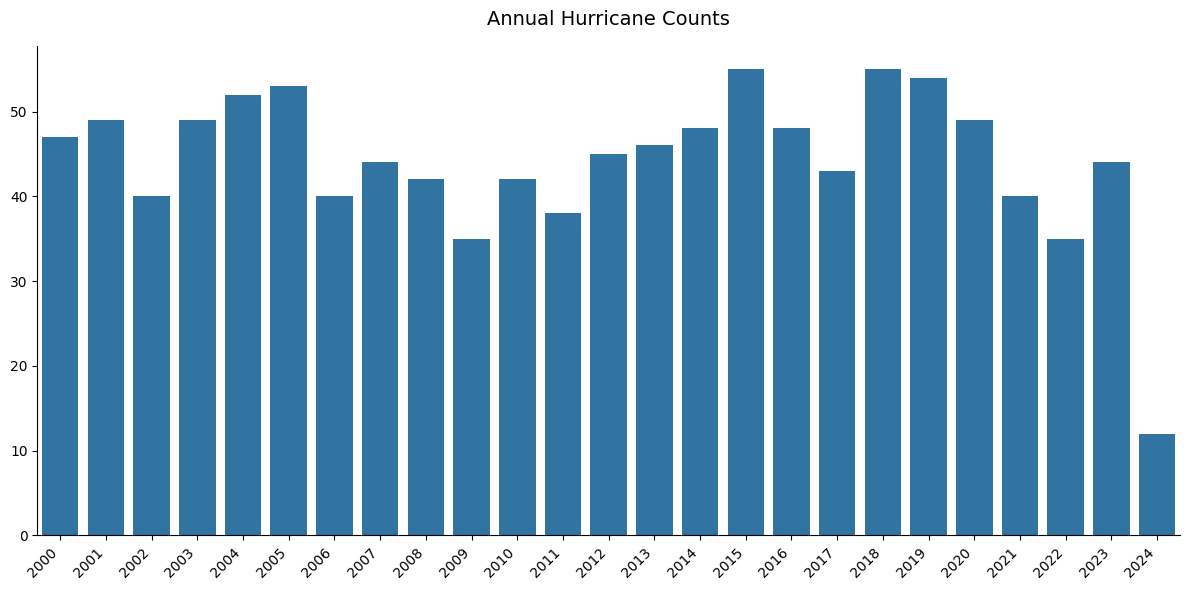

In [260]:
yearly_counts = (
    hurricanes_max
    .query("2000 <= season <= 2024")
    .groupby(['season'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=yearly_counts,
    x='season',
    y='count'
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.set_title("Annual Hurricane Counts", fontsize=14, pad=15)

plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()
plt.show()

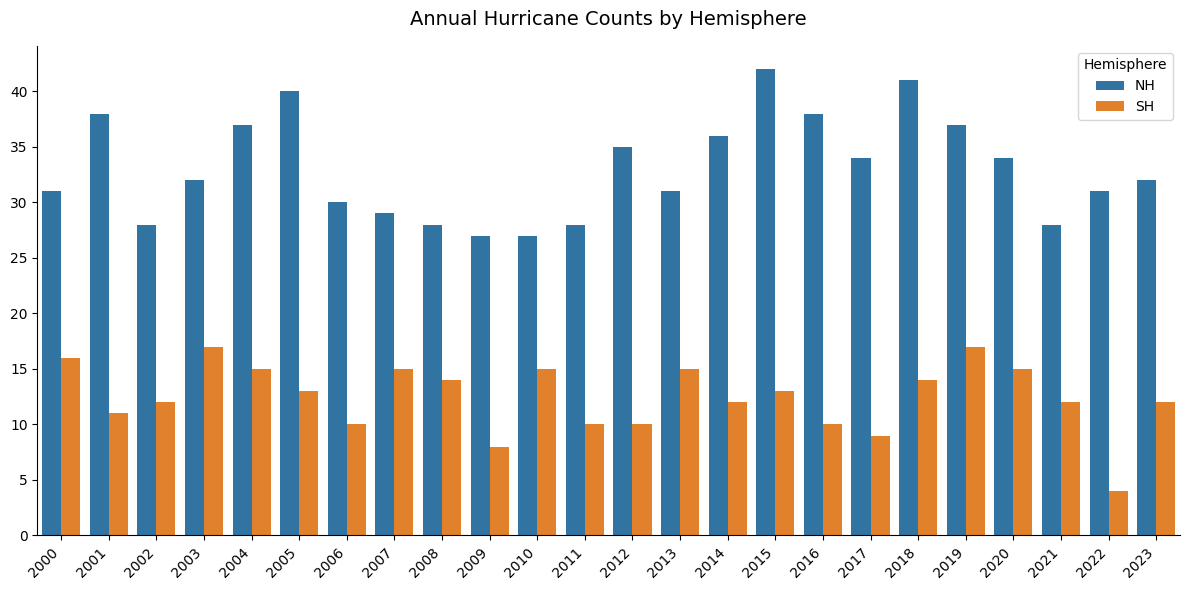

In [93]:
yearly_counts_hemi = (
    hurricanes_max
    .query("2000 <= season < 2024")
    .groupby(['season', 'hemisphere'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=yearly_counts_hemi,
    x='season',
    y='count',
    hue='hemisphere'
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.set_title("Annual Hurricane Counts by Hemisphere", fontsize=14, pad=15)
ax.legend(title="Hemisphere")

plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()
plt.show()

In [186]:
temperature_df.head()

,hemisphere,year,month,date,temp,fahrenheit,temp_f
0,NH,1880,Apr,1880-04-15,-0.31,31.442,31.442
1,NH,1880,Aug,1880-08-15,-0.28,31.496,31.496
2,NH,1880,Dec,1880-12-15,-0.41,31.262,31.262
3,NH,1880,Feb,1880-02-15,-0.52,31.064,31.064
4,NH,1880,Jan,1880-01-15,-0.37,31.334,31.334


In [ ]:
hurricanes_lm = hurricanes_max.merge(temperature_df, how='left', left_on=['month_15', 'hemisphere'], right_on=['date', 'hemisphere'])
hurricanes_lm

,season,sid,basin,latitude,longitude,iso_time,usa_sshs,usa_wind,_parsed_dt,month_15,year_x,hemisphere,year_y,month,date,temp,fahrenheit,temp_f
0,1998,1998281N11151,WP,17.00000,122.7250,1998-10-14 00:00:00 UTC,5,155.0,1998-10-14 00:00:00+00:00,1998-10-15,1998,NH,1998,Oct,1998-10-15,0.53,32.954,32.954
1,2014,2014209N12152,WP,15.39250,133.5130,2014-08-03 03:00:00 UTC,5,137.0,2014-08-03 03:00:00+00:00,2014-08-15,2014,NH,2014,Aug,2014-08-15,0.91,33.638,33.638
2,2014,2014092S11159,SP,-13.00620,146.2270,2014-04-10 15:00:00 UTC,5,140.0,2014-04-10 15:00:00+00:00,2014-04-15,2014,SH,2014,Apr,2014-04-15,0.52,32.936,32.936
3,2014,2013350S08099,SI,-15.23120,83.0075,2013-12-21 09:00:00 UTC,5,137.0,2013-12-21 09:00:00+00:00,2013-12-15,2013,SH,2013,Dec,2013-12-15,0.55,32.990,32.990
4,2015,2015226N15164,WP,20.03500,150.8460,2015-08-19 15:00:00 UTC,5,137.0,2015-08-19 15:00:00+00:00,2015-08-15,2015,NH,2015,Aug,2015-08-15,1.01,33.818,33.818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,2013,2013228N23124,WP,24.84980,125.3140,2013-08-20 21:00:00 UTC,1,65.0,2013-08-20 21:00:00+00:00,2013-08-15,2013,NH,2013,Aug,2013-08-15,0.73,33.314,33.314
1674,2010,2010019S11123,SI,-14.30000,123.5000,2010-01-21 06:00:00 UTC,1,65.0,2010-01-21 06:00:00+00:00,2010-01-15,2010,SH,2010,Jan,2010-01-15,0.69,33.242,33.242
1675,2005,2004312S05085,SI,-10.90000,77.2667,2004-11-09 00:00:00 UTC,1,65.0,2004-11-09 00:00:00+00:00,2004-11-15,2004,SH,2004,Nov,2004-11-15,0.48,32.864,32.864
1676,1992,1992311N06107,NI,7.55494,78.5574,1992-11-13 03:00:00 UTC,1,65.0,1992-11-13 03:00:00+00:00,1992-11-15,1992,NH,1992,Nov,1992-11-15,-0.09,31.838,31.838


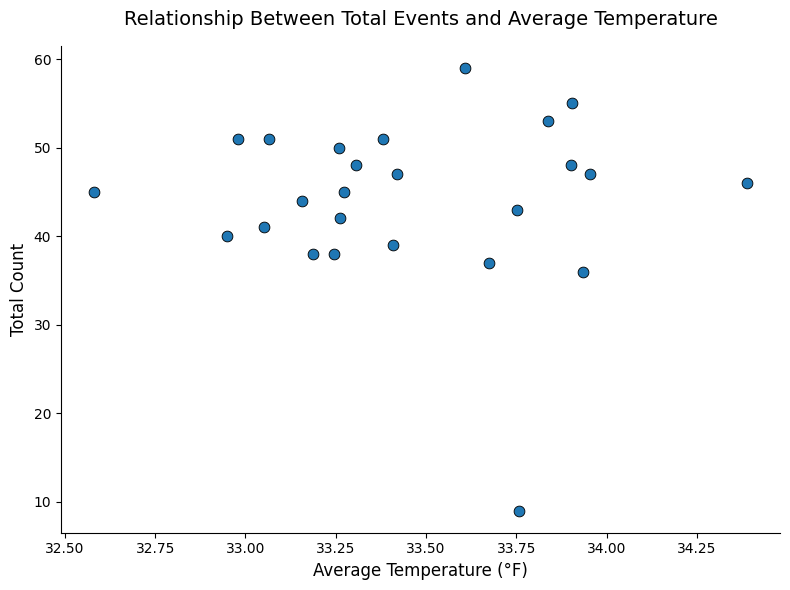

In [191]:
hurricanes_grouped = hurricanes_lm.groupby(['year_x']).agg(total=('temp_f', 'count'), avg_temp_f =('temp_f', 'mean')).reset_index()
hurricanes_grouped = hurricanes_grouped[hurricanes_grouped['year_x'] >= 2000]
hurricanes_grouped

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=hurricanes_grouped,
    x='avg_temp_f',
    y='total',
    s=60,
    color='tab:blue',
    edgecolor='black'
)

plt.title('Relationship Between Total Events and Average Temperature', fontsize=14, pad=15)
plt.xlabel('Average Temperature (°F)', fontsize=12)
plt.ylabel('Total Count', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_15841/3254445647.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




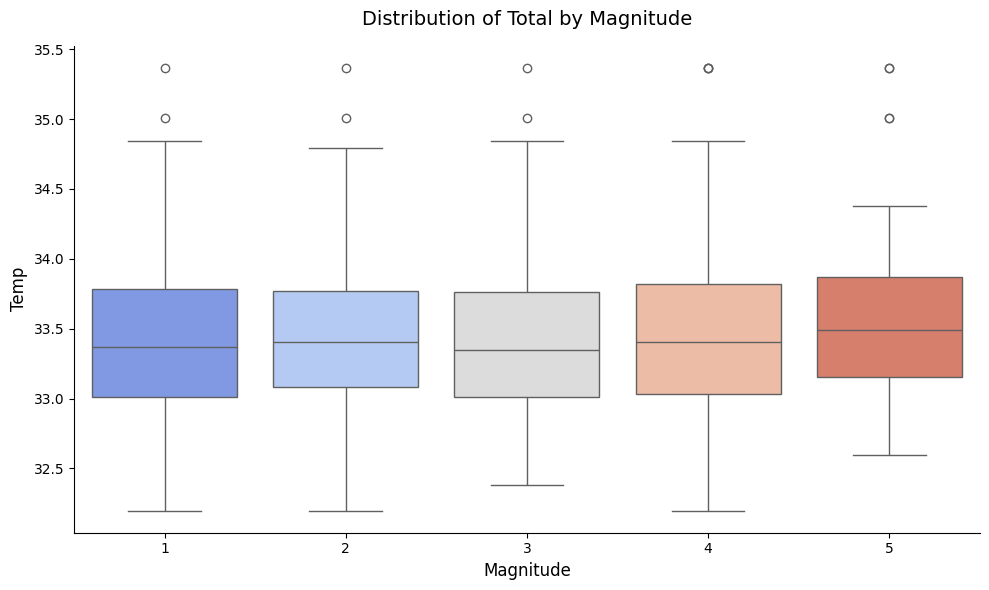

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

hurricanes_lm_filtered = hurricanes_lm[(hurricanes_lm['usa_sshs'] != -9) & (hurricanes_lm['year_x'] >= 2000)]

sns.boxplot(
    data=hurricanes_lm_filtered,
    x='usa_sshs',
    y='temp_f',
    palette='coolwarm',
    showfliers=True  # show outliers as dots
)

plt.title('Distribution of Total by Magnitude', fontsize=14, pad=15)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Temp', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [250]:
hurricanes_severe = hurricanes_lm_filtered[hurricanes_lm_filtered['usa_sshs'] >= 3]

In [251]:
hurricanes_severe.head()

,season,sid,basin,latitude,longitude,iso_time,usa_sshs,usa_wind,_parsed_dt,month_15,year_x,hemisphere,year_y,month,date,temp,fahrenheit,temp_f
1,2014,2014209N12152,WP,15.3925,133.5130,2014-08-03 03:00:00 UTC,5,137.0,2014-08-03 03:00:00+00:00,2014-08-15,2014,NH,2014,Aug,2014-08-15,0.91,33.638,33.638
2,2014,2014092S11159,SP,-13.0062,146.2270,2014-04-10 15:00:00 UTC,5,140.0,2014-04-10 15:00:00+00:00,2014-04-15,2014,SH,2014,Apr,2014-04-15,0.52,32.936,32.936
3,2014,2013350S08099,SI,-15.2312,83.0075,2013-12-21 09:00:00 UTC,5,137.0,2013-12-21 09:00:00+00:00,2013-12-15,2013,SH,2013,Dec,2013-12-15,0.55,32.990,32.990
4,2015,2015226N15164,WP,20.0350,150.8460,2015-08-19 15:00:00 UTC,5,137.0,2015-08-19 15:00:00+00:00,2015-08-15,2015,NH,2015,Aug,2015-08-15,1.01,33.818,33.818
5,2015,2015293N13266,EP,17.7590,-105.4920,2015-10-23 15:00:00 UTC,5,182.0,2015-10-23 15:00:00+00:00,2015-10-15,2015,NH,2015,Oct,2015-10-15,1.28,34.304,34.304


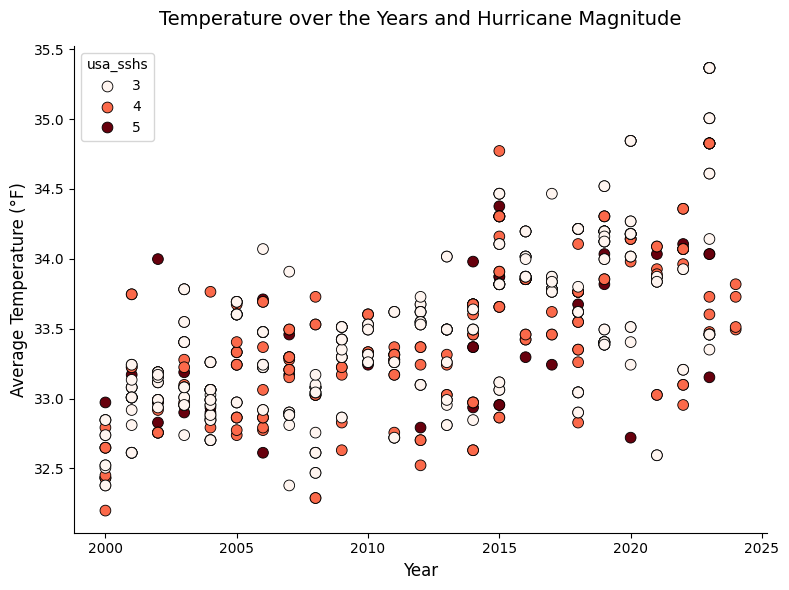

In [252]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=hurricanes_severe,
    x='year_x',
    y='temp_f',
    hue='usa_sshs',
    s=60,
    color='tab:blue',
    edgecolor='black',
    palette='Reds'
)

plt.title('Temperature over the Years and Hurricane Magnitude', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°F)', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

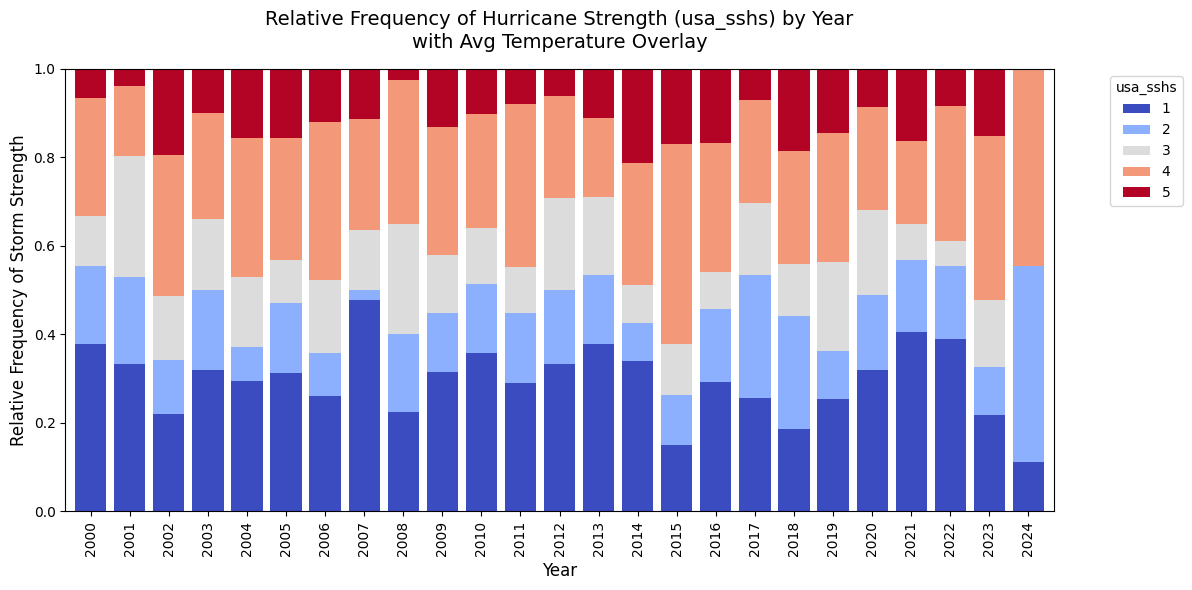

In [ ]:
# --- 1. Compute relative frequency of hurricane strength per year ---
freq = (
    hurricanes_lm_filtered.groupby(['year_x', 'usa_sshs'])
    .size()
    .unstack(fill_value=0)
)

# Convert counts to proportions (relative frequencies)
freq = freq.div(freq.sum(axis=1), axis=0)

# --- 2. Compute mean temperature per year ---
temp_by_year = hurricanes_lm_filtered.groupby('year_x')['temp_f'].mean()

# --- 3. Plot setup ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- 4. Stacked bar of hurricane category proportions ---
freq.plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    colormap='coolwarm',
    width=0.8
)

ax1.set_ylabel('Relative Frequency of Storm Strength', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_title('Relative Frequency of Hurricane Strength (usa_sshs) by Year\nwith Avg Temperature Overlay', fontsize=14, pad=15)
ax1.legend(title='usa_sshs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim(0, 1)


# --- 6. Legend for both axes ---
lines1, labels1 = ax1.get_legend_handles_labels()
plt.tight_layout()
plt.show()


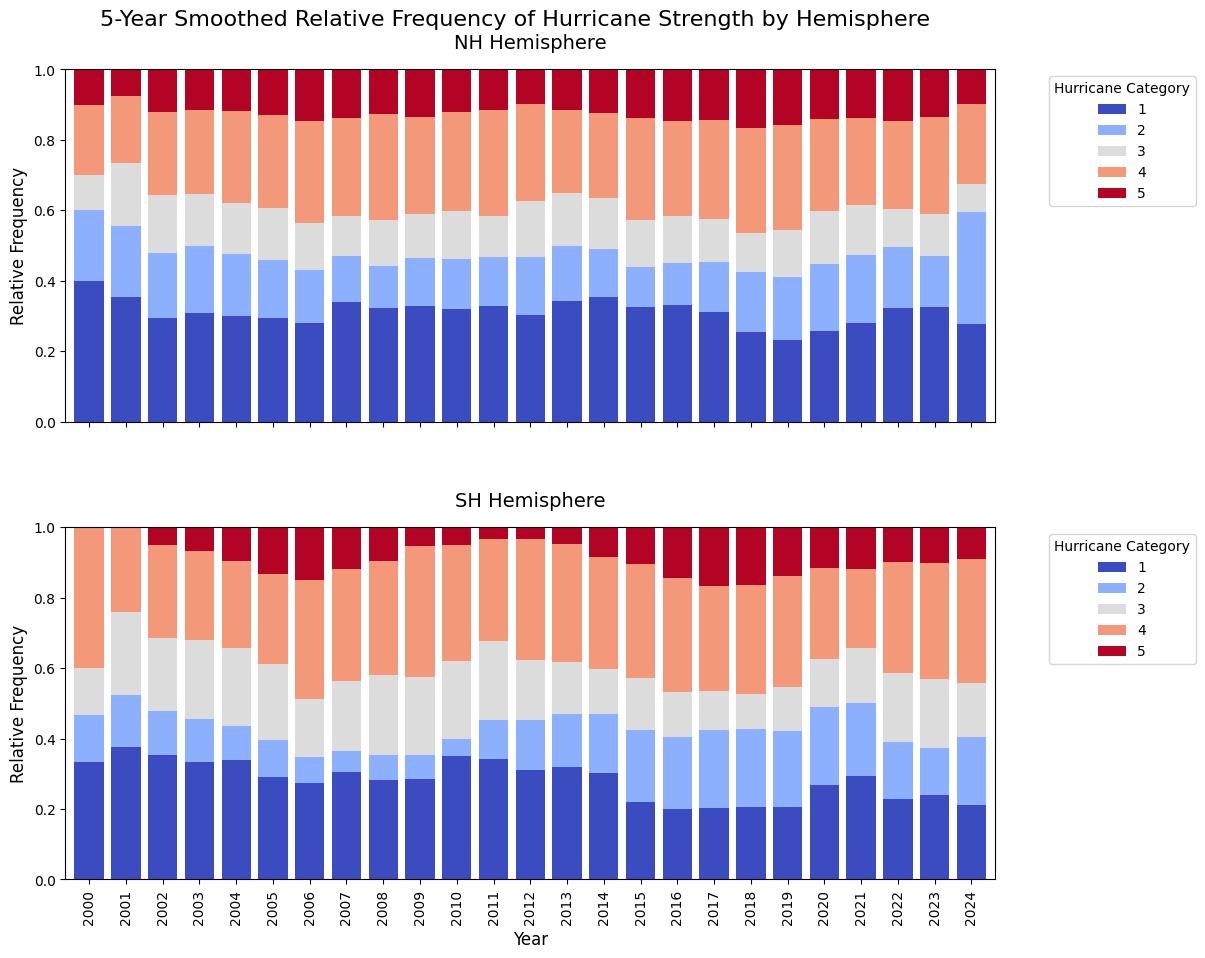

In [254]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Compute relative frequency of hurricane strength per year and hemisphere ---
freq = (
    hurricanes_lm_filtered
    .groupby(['hemisphere', 'year_x', 'usa_sshs'])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions within each hemisphere-year
freq = freq.div(freq.sum(axis=1), axis=0)

# Apply 5-year rolling mean within each hemisphere
freq_rolling = (
    freq.groupby(level=0)
    .apply(lambda x: x.rolling(window=5, min_periods=1).mean())
)

# --- 2. Plot setup: stacked vertically (shared x-axis) ---
hemispheres = freq_rolling.index.get_level_values(0).unique()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True, sharey=True)

for ax, hemi in zip(axes, hemispheres):
    data = freq_rolling.loc[hemi].reset_index()  # makes year_x a column
    data.plot(
        x='year_x',
        kind='bar',
        stacked=True,
        ax=ax,
        colormap='coolwarm',
        width=0.8
    )

    ax.set_title(f'{hemi} Hemisphere', fontsize=14, pad=15)  # increased pad
    ax.set_ylabel('Relative Frequency', fontsize=12)
    ax.legend(title='Hurricane Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 1)

axes[-1].set_xlabel('Year', fontsize=12)

ax.tick_params(axis='x', rotation=90)



# Add a figure title with adjusted spacing
fig.suptitle(
    '5-Year Smoothed Relative Frequency of Hurricane Strength by Hemisphere',
    fontsize=16,
    y=0.98  # move up to prevent overlap
)

# Adjust overall layout to prevent overlap
plt.subplots_adjust(top=0.92, hspace=0.3)
plt.show()


For hurricanes, the threshold for being considered **“severe”** is generally **Category 3 or higher** on the **Saffir–Simpson Hurricane Wind Scale**.

Here’s the breakdown:

| **Category**       | **Wind Speed (mph)** | **Damage Potential**                                                      | **Severity Classification**  |
| ------------------ | -------------------- | ------------------------------------------------------------------------- | ---------------------------- |
| **Tropical Storm** | 39–73                | Strong winds, heavy rain, minor damage                                    | Not severe                   |
| **Category 1**     | 74–95                | Minimal damage (roof shingles, trees, power lines)                        | Moderate                     |
| **Category 2**     | 96–110               | Extensive damage (major roof and siding damage, power outages)            | Strong                       |
| **Category 3**     | 111–129              | **Devastating damage** (many trees uprooted, major structural damage)     | **Severe / Major Hurricane** |
| **Category 4**     | 130–156              | **Catastrophic damage** (severe structural failure, power loss for weeks) | **Severe / Major Hurricane** |
| **Category 5**     | ≥157                 | **Total devastation** (homes destroyed, uninhabitable areas)              | **Severe / Major Hurricane** |


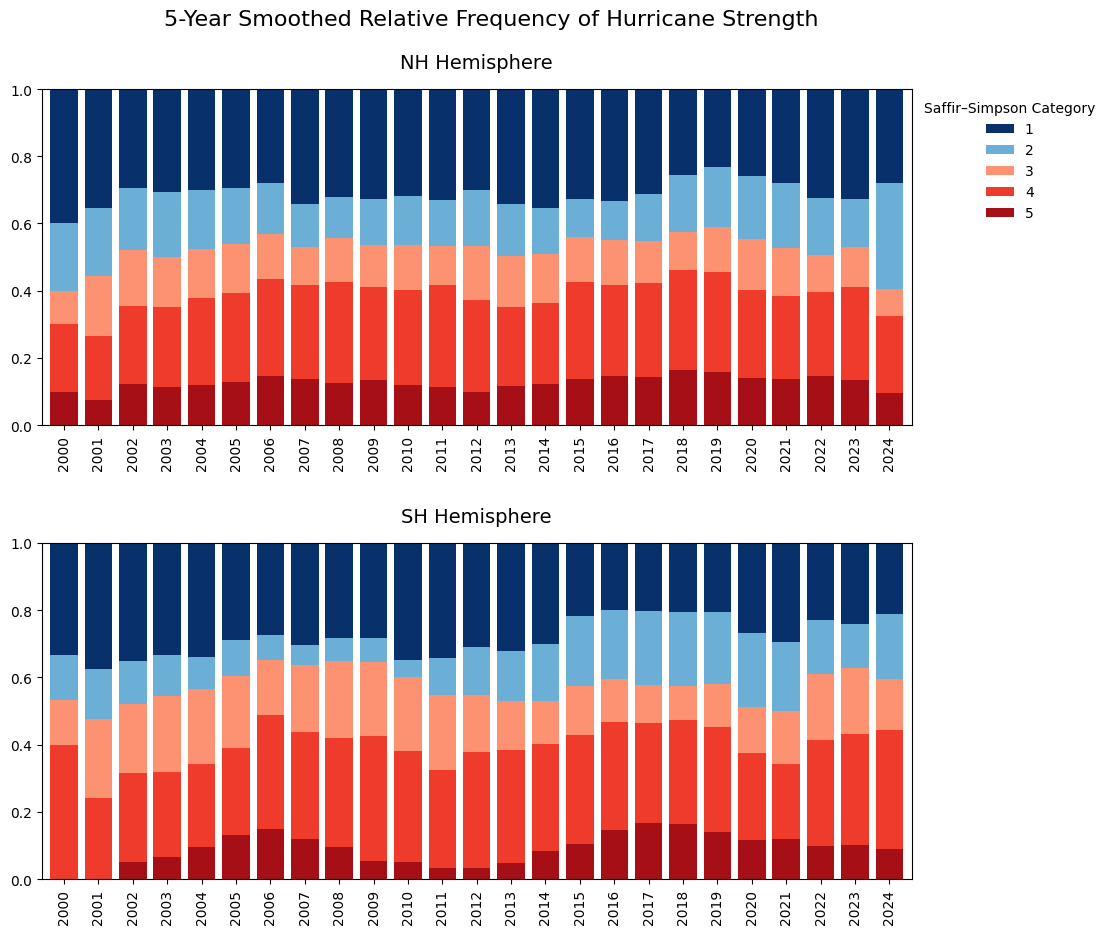

In [266]:
# --- 1. Compute relative frequency of hurricane strength per year and hemisphere ---
freq = (
    hurricanes_lm_filtered
    .groupby(['hemisphere', 'year_x', 'usa_sshs'])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions within each hemisphere-year
freq = freq.div(freq.sum(axis=1), axis=0)

# Apply 5-year rolling mean within each hemisphere
freq_rolling = (
    freq.groupby(level=0)
        .apply(lambda x: x.rolling(window=5, min_periods=1).mean())
)

# --- 2. Reverse stacking order (Category 5 bottom → 1 top) ---
freq_rolling = freq_rolling[sorted(freq_rolling.columns, reverse=True)]

# --- 3. Define custom color palette (3–5 reds, 1–2 blues) ---
palette = {
    5: "#a50f15",  # dark red
    4: "#ef3b2c",  # medium red
    3: "#fc9272",  # light red
    2: "#6baed6",  # light blue
    1: "#08306b",  # dark blue,
    0: "#deebf7"   # optional
}

# --- 4. Plot setup: stacked vertically (each with x-axis labels) ---
hemispheres = freq_rolling.index.get_level_values(0).unique()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=False, sharey=True)

# Placeholder for legend handles/labels
legend_handles, legend_labels = None, None

for ax, hemi in zip(axes, hemispheres):
    # Prepare data for this hemisphere
    data = freq_rolling.loc[hemi].reset_index()
    cat_cols = [c for c in freq_rolling.columns if c in palette]
    colors = [palette[c] for c in cat_cols]

    data[cat_cols + ['year_x']].plot(
        x='year_x',
        kind='bar',
        stacked=True,
        ax=ax,
        color=colors,
        width=0.8
    )

    ax.set_title(f'{hemi} Hemisphere', fontsize=14, pad=15)
    ax.set_ylabel('', fontsize=12)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('', fontsize=12)

    # Capture legend info once (from the first subplot)
    if legend_handles is None:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles, legend_labels = handles[::-1], labels[::-1]

    # Remove legends from each subplot
    ax.get_legend().remove()

# --- 5. Add one shared legend to the figure ---
fig.legend(
    legend_handles,
    legend_labels,
    title='Saffir–Simpson Category',
    bbox_to_anchor=(0.85, 0.9),
    loc='upper left',
    frameon=False
)

# --- 6. Figure title & layout ---
fig.suptitle(
    '5-Year Smoothed Relative Frequency of Hurricane Strength',
    fontsize=16,
    y=0.98
)

plt.subplots_adjust(top=0.9, hspace=0.35, right=0.85)
plt.show()


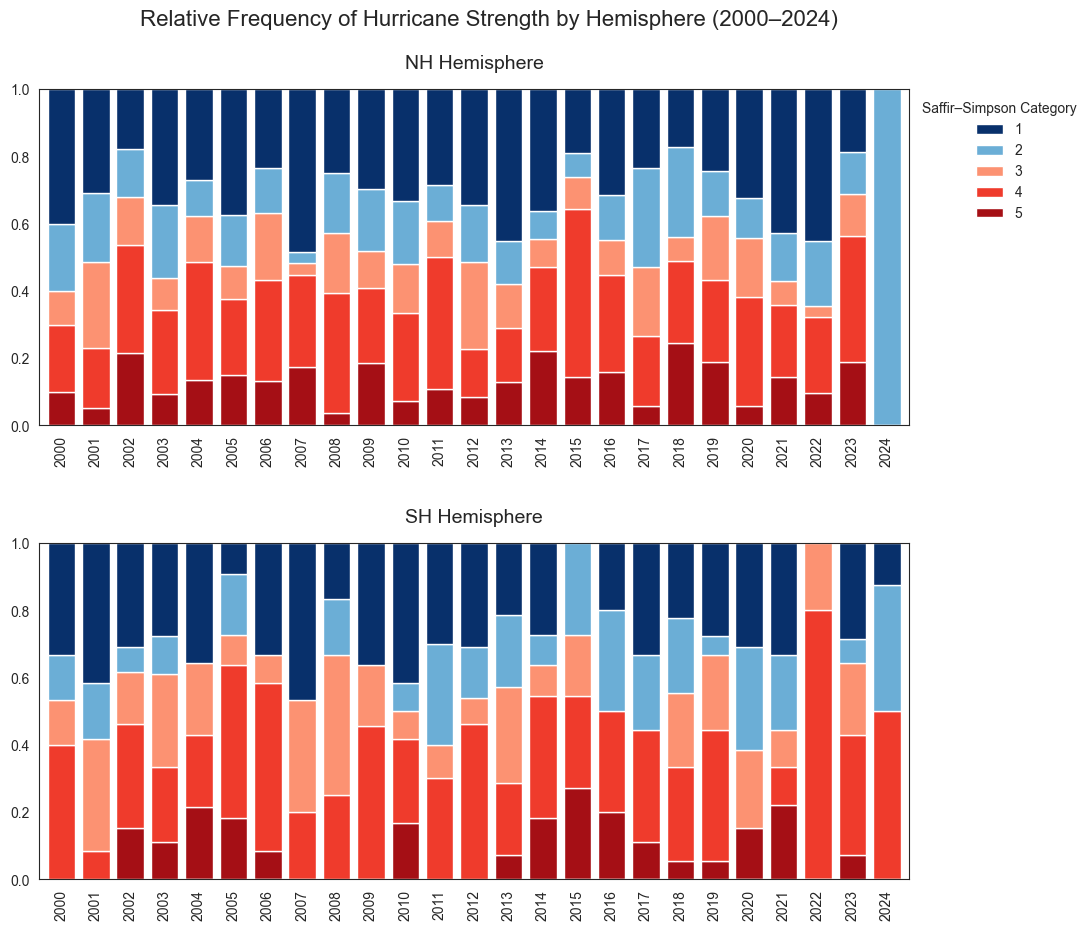

In [269]:
# --- 1. Compute relative frequency of hurricane strength per year and hemisphere ---
freq = (
    hurricanes_lm_filtered
    .groupby(['hemisphere', 'year_x', 'usa_sshs'])
    .size()
    .unstack(fill_value=0)
)

# Convert to proportions within each hemisphere-year
freq = freq.div(freq.sum(axis=1), axis=0)

# --- 2. Reverse stacking order (Category 5 bottom → 1 top) ---
freq = freq[sorted(freq.columns, reverse=True)]

# --- 3. Define custom color palette (3–5 reds, 1–2 blues) ---
palette = {
    5: "#a50f15",  # dark red
    4: "#ef3b2c",  # medium red
    3: "#fc9272",  # light red
    2: "#6baed6",  # light blue
    1: "#08306b",  # dark blue,
    0: "#deebf7"   # optional
}

# --- 4. Plot setup: stacked vertically (each with x-axis labels) ---
hemispheres = freq.index.get_level_values(0).unique()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=False, sharey=True)

# Placeholder for legend handles/labels
legend_handles, legend_labels = None, None

for ax, hemi in zip(axes, hemispheres):
    # Prepare data for this hemisphere
    data = freq.loc[hemi].reset_index()
    cat_cols = [c for c in freq.columns if c in palette]
    colors = [palette[c] for c in cat_cols]

    data[cat_cols + ['year_x']].plot(
        x='year_x',
        kind='bar',
        stacked=True,
        ax=ax,
        color=colors,
        width=0.8
    )

    ax.set_title(f'{hemi} Hemisphere', fontsize=14, pad=15)
    ax.set_ylabel('', fontsize=12)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('', fontsize=12)

    # Capture legend info once (from the first subplot)
    if legend_handles is None:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles, legend_labels = handles[::-1], labels[::-1]

    # Remove legends from each subplot
    ax.get_legend().remove()

# --- 5. Add one shared legend to the figure ---
fig.legend(
    legend_handles,
    legend_labels,
    title='Saffir–Simpson Category',
    bbox_to_anchor=(0.85, 0.9),
    loc='upper left',
    frameon=False
)

# --- 6. Figure title & layout ---
fig.suptitle(
    'Relative Frequency of Hurricane Strength by Hemisphere (2000–2024)',
    fontsize=16,
    y=0.98
)

plt.subplots_adjust(top=0.9, hspace=0.35, right=0.85)
plt.show()


/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_15841/4047160959.py:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



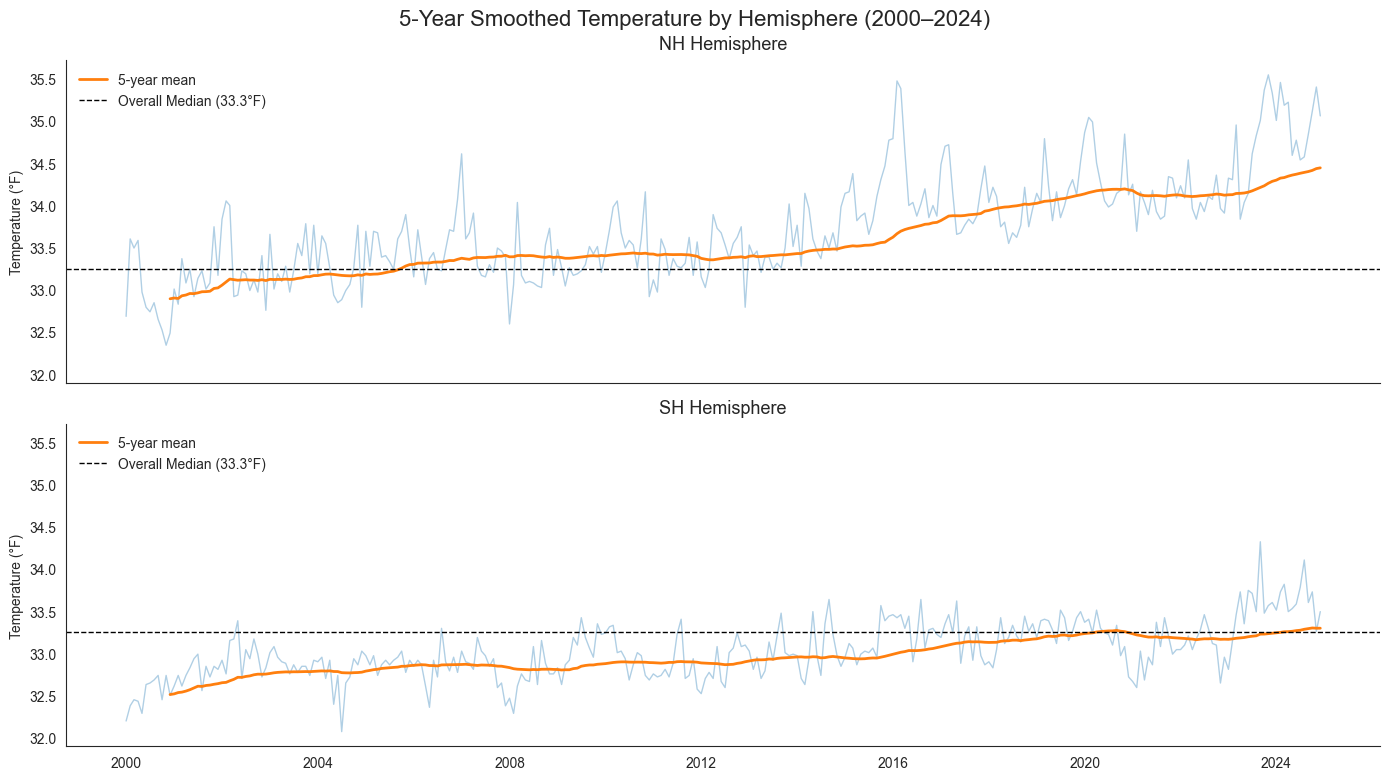

In [ ]:
# --- 1) Prep and monthly resample ---
df = temperature_filtered.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# If your data are monthly already, this keeps them monthly.
# If there are gaps, resample fills the monthly index before smoothing.
monthly = (
    df.set_index('date')
      .groupby('hemisphere')['temp_f']
      .resample('MS').mean()           # monthly start
      .reset_index()
)

# --- 2) 5-year rolling mean within each hemisphere (60 months) ---
smoothed = (
    monthly
    .groupby('hemisphere', group_keys=False)
    .apply(lambda x: x.assign(temp_f_5yr=x['temp_f'].rolling(window=60, min_periods=12).mean()))
)

overall_median = df['temp_f'].median()

# --- 3) Plot: split by hemisphere, NH on top, SH below ---
hemi_order = ['NH', 'SH']  # ensures panel order
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True, sharey=True)

for ax, hemi in zip(axes, hemi_order):
    sub_raw = monthly[monthly['hemisphere'] == hemi]
    sub_smooth = smoothed[smoothed['hemisphere'] == hemi]

    # optional faint raw line for context
    sns.lineplot(data=sub_raw, x='date', y='temp_f', ax=ax, linewidth=1, alpha=0.35, label='Monthly')

    # 5-year rolling mean
    sns.lineplot(data=sub_smooth, x='date', y='temp_f_5yr', ax=ax, linewidth=2, label='5-year mean')

    # overall median reference
    ax.axhline(overall_median, color='black', linestyle='--', linewidth=1, label=f'Overall Median ({overall_median:.1f}°F)')

    ax.set_title(f'{hemi} Hemisphere', fontsize=13, pad=8)
    ax.set_xlabel('')
    ax.set_ylabel('Temperature (°F)')

    # Clean up legends per panel
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[handles[1], handles[2]], labels=[labels[1], labels[2]], frameon=False, loc='upper left')

fig.suptitle('5-Year Smoothed Temperature by Hemisphere (2000–2024)', fontsize=16, y=0.97)
sns.despine()
plt.tight_layout()
plt.show()


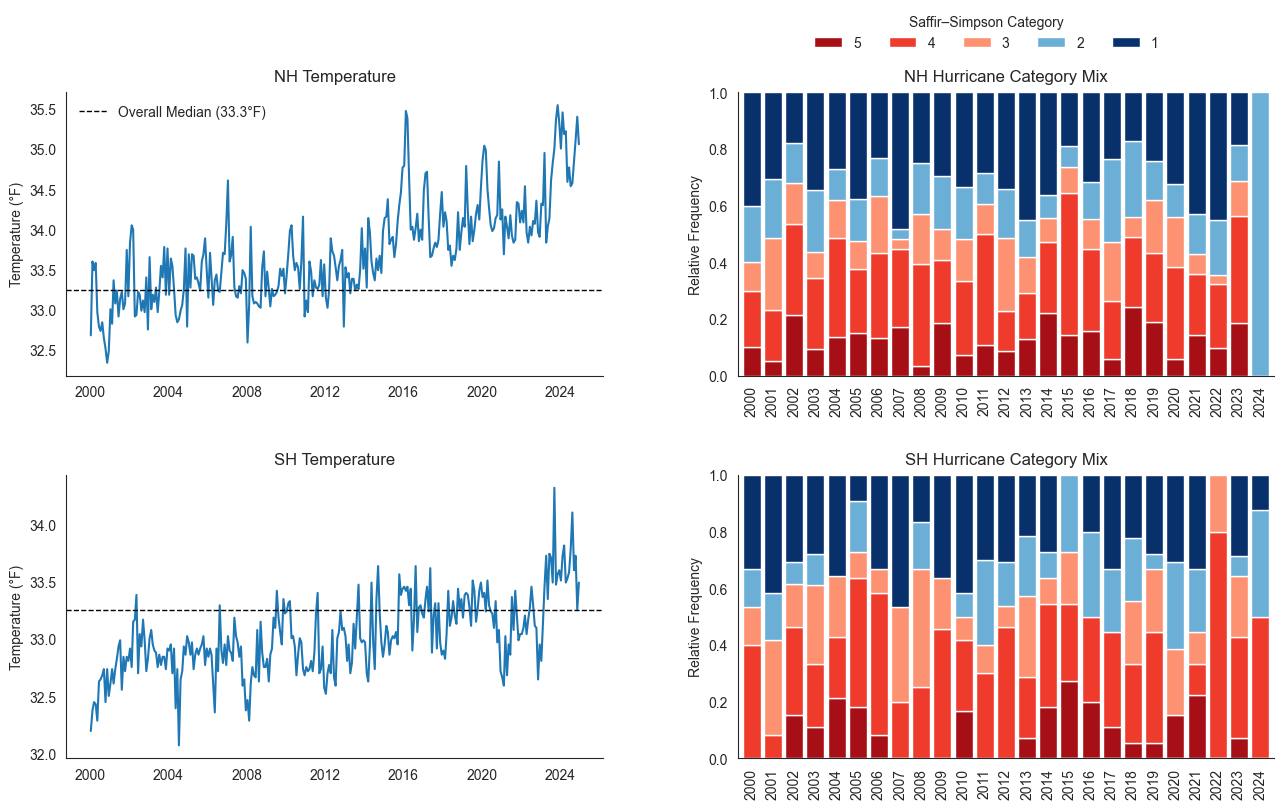

In [289]:
# Order and colors
hemi_order = ['NH', 'SH']
cat_cols = sorted([c for c in freq.columns if isinstance(c, (int, float))], reverse=True)
palette = {
    5: "#a50f15", 4: "#ef3b2c", 3: "#fc9272",
    2: "#6baed6", 1: "#08306b", 0: "#deebf7"
}
cat_colors = [palette[c] for c in cat_cols]

# Shared refs
overall_median = temperature_filtered['temp_f'].median()

# --- Figure layout: 2 rows (NH, SH) x 2 cols (Temp, Hurricane mix) ---
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), sharex=False, sharey=False)  # <--- changed here

legend_handles, legend_labels = None, None

for r, hemi in enumerate(hemi_order):
    # ----- Left: Temperature line for this hemisphere -----
    ax_t = axes[r, 0]
    sub = temperature_filtered[temperature_filtered['hemisphere'] == hemi].copy()
    sub = sub.sort_values('date')

    sns.lineplot(data=sub, x='date', y='temp_f', ax=ax_t, linewidth=1.5)
    ax_t.axhline(overall_median, color='black', linestyle='--', linewidth=1,
                label=f'Overall Median ({overall_median:.1f}°F)')
    ax_t.set_title(f'{hemi} Temperature', fontsize=12, pad=8)
    ax_t.set_xlabel('')
    ax_t.set_ylabel('Temperature (°F)')

    if r == 0:
        ax_t.legend(frameon=False, loc='upper left')
    else:
        if ax_t.get_legend() is not None:
            ax_t.get_legend().remove()

    # ----- Right: Stacked bars of relative frequency by category -----
    ax_h = axes[r, 1]
    data = freq.loc[hemi].reset_index()  # columns: year_x + categories
    data.plot(x='year_x', y=cat_cols, kind='bar', stacked=True,
              ax=ax_h, color=cat_colors, width=0.85, legend=False)

    ax_h.set_title(f'{hemi} Hurricane Category Mix', fontsize=12, pad=8)
    ax_h.set_xlabel('')
    ax_h.set_ylabel('Relative Frequency')
    ax_h.set_ylim(0, 1)
    ax_h.tick_params(axis='x', rotation=90)

    # capture legend once from this axis
    if legend_handles is None:
        handles, labels = ax_h.get_legend_handles_labels()
        legend_handles, legend_labels = handles, [str(c) for c in cat_cols]

# --- Shared legend for categories (moved to top center) ---
fig.legend(
    legend_handles, legend_labels,
    title='Saffir–Simpson Category',
    loc='upper center',             # position it at the top
    bbox_to_anchor=(0.7, 0.95),     # center horizontally, slightly above the plots
    ncol=len(cat_cols),             # place legend items in one horizontal row
    frameon=False
)

# Adjust layout so legend doesn’t overlap
plt.subplots_adjust(top=0.85, right=0.88, hspace=0.35, wspace=0.25)


fig.suptitle('', fontsize=16, y=0.98)
sns.despine()
plt.show()


### Tornadoes

In [256]:
# Load
df = pd.read_csv("1950-2024_actual_tornadoes.csv")

# Ensure types
df['slat'] = pd.to_numeric(df.get('slat'), errors='coerce')
df['slon'] = pd.to_numeric(df.get('slon'), errors='coerce')
df['date'] = pd.to_datetime(df.get('date'), errors='coerce', infer_datetime_format=True)

# Mid-month column set to the 15th of each record's month
month_start = df['date'].dt.to_period('M').dt.start_time
df['mid_month'] = month_start + pd.offsets.Day(14)  # 1st + 14 days = 15th

# Hemisphere from latitude
# NH if latitude > 0, SH if latitude < 0, Equator if exactly 0, NA if missing
df['hemisphere'] = np.where(
    df['slat'].isna(), pd.NA,
    np.where(df['slat'] > 0, 'NH',
             np.where(df['slat'] < 0, 'SH', 'Equator'))
)

tornadoes_df = df.copy()


/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_15841/2110463298.py:7: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [257]:
tornadoes_df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,ns,sn,sg,f1,f2,f3,f4,fc,mid_month,hemisphere
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,1,1,1,25,0,0,0,0,1950-10-15,NH
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,1,1,1,47,0,0,0,0,1950-10-15,NH
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,1,1,1,177,0,0,0,0,1950-11-15,NH
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,1,1,1,209,0,0,0,0,1950-11-15,NH
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,1,1,1,101,0,0,0,0,1950-11-15,NH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71808,624887,2024,9,7,2024-09-07,05:58:00,3,IN,18,0,...,1,1,1,127,0,0,0,0,2024-09-15,NH
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,1,1,1,17,0,0,0,0,2024-09-15,NH
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,1,1,1,29,0,0,0,0,2024-09-15,NH
71811,624890,2024,9,9,2024-09-09,15:15:00,3,NY,36,0,...,1,1,1,45,0,0,0,0,2024-09-15,NH


In [258]:
tornadoes_filtered_df = tornadoes_df[(tornadoes_df['sn'] == 1) & (tornadoes_df['mag'] != -9)]
tornadoes_filtered_df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,ns,sn,sg,f1,f2,f3,f4,fc,mid_month,hemisphere
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,1,1,1,25,0,0,0,0,1950-10-15,NH
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,1,1,1,47,0,0,0,0,1950-10-15,NH
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,1,1,1,177,0,0,0,0,1950-11-15,NH
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,1,1,1,209,0,0,0,0,1950-11-15,NH
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,1,1,1,101,0,0,0,0,1950-11-15,NH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71806,624885,2024,9,5,2024-09-05,13:30:00,3,OK,40,0,...,1,1,1,73,0,0,0,0,2024-09-15,NH
71807,624886,2024,9,6,2024-09-06,19:34:00,3,NY,36,0,...,1,1,1,3,0,0,0,0,2024-09-15,NH
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,1,1,1,17,0,0,0,0,2024-09-15,NH
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,1,1,1,29,0,0,0,0,2024-09-15,NH


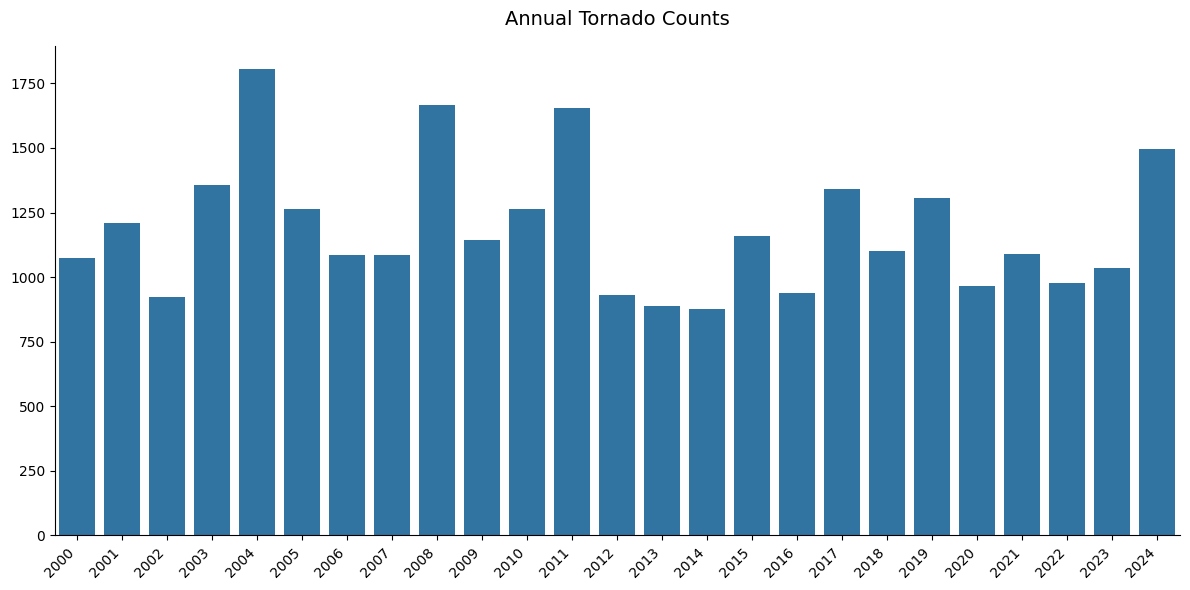

In [142]:
yearly_counts = (
    tornadoes_filtered_df
    .query("2000 <= yr <= 2024")
    .groupby(['yr'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=yearly_counts,
    x='yr',
    y='count'
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.set_title("Annual Tornado Counts", fontsize=14, pad=15)

plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()
plt.show()

## Merge Datasets

In [165]:
tornados_lm = tornadoes_df.merge(temperature_df, how='left', left_on=['mid_month', 'hemisphere'], right_on=['date', 'hemisphere'])
tornados_grouped = tornados_lm.groupby(['year']).agg(total=('temp_f', 'count'), avg_temp_f =('temp_f', 'mean')).reset_index()
tornados_grouped = tornados_grouped[tornados_grouped['year'] >= 2000]
tornados_grouped

,year,total,avg_temp_f
50,2000,1075,32.984876
51,2001,1215,33.150800
52,2002,934,33.088094
53,2003,1374,33.197616
54,2004,1817,33.068221
55,2005,1263,33.511644
56,2006,1103,33.359873
57,2007,1095,33.473797
58,2008,1689,33.148398
59,2009,1156,33.214517


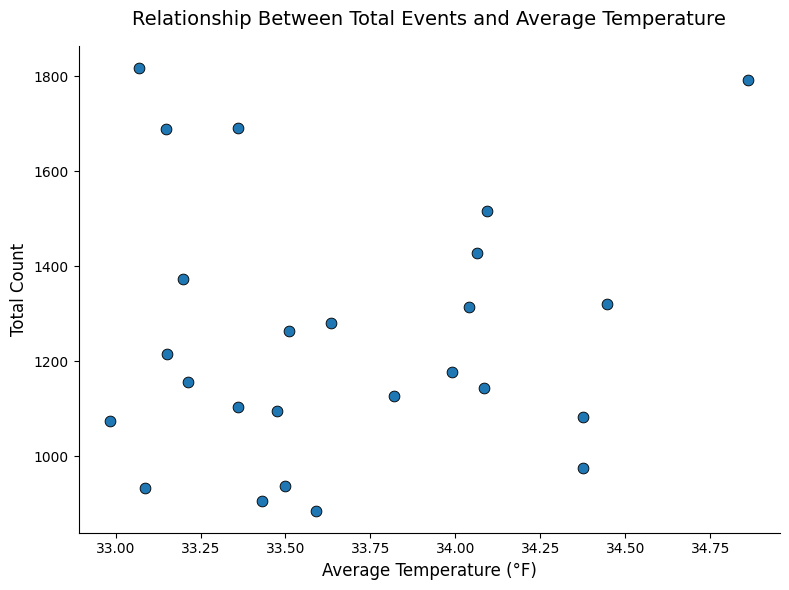

In [146]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=tornados_grouped,
    x='avg_temp_f',
    y='total',
    s=60,
    color='tab:blue',
    edgecolor='black'
)

plt.title('Relationship Between Total Events and Average Temperature', fontsize=14, pad=15)
plt.xlabel('Average Temperature (°F)', fontsize=12)
plt.ylabel('Total Count', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

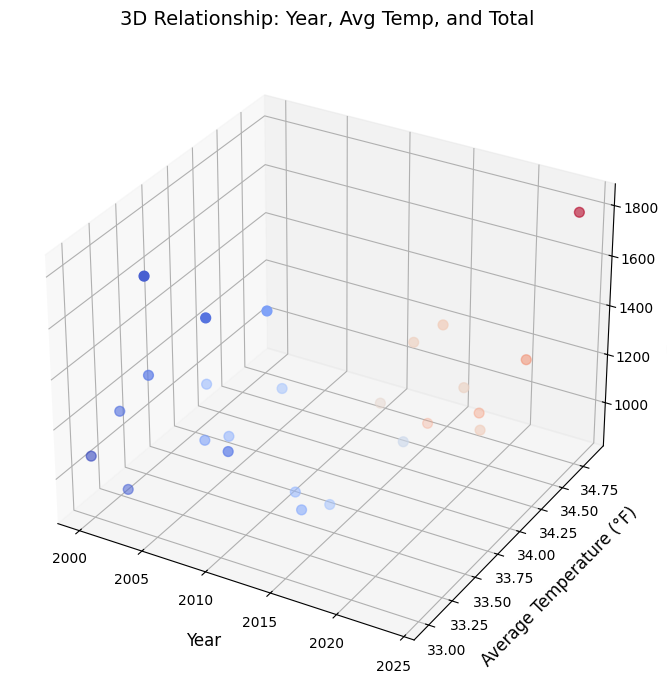

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection

# Create 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(
    tornados_grouped['year'],
    tornados_grouped['avg_temp_f'],
    tornados_grouped['total'],
    c=tornados_grouped['avg_temp_f'],  # color by temp for clarity
    cmap='coolwarm',
    s=50
)

# Axis labels
ax.set_xlabel('Year', fontsize=12, labelpad=10)
ax.set_ylabel('Average Temperature (°F)', fontsize=12, labelpad=10)
ax.set_zlabel('Total Count', fontsize=12, labelpad=10)
ax.set_title('3D Relationship: Year, Avg Temp, and Total', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

In [148]:
tornadoes_filtered_df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,ns,sn,sg,f1,f2,f3,f4,fc,mid_month,hemisphere
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,1,1,1,25,0,0,0,0,1950-10-15,NH
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,1,1,1,47,0,0,0,0,1950-10-15,NH
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,1,1,1,177,0,0,0,0,1950-11-15,NH
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,1,1,1,209,0,0,0,0,1950-11-15,NH
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,1,1,1,101,0,0,0,0,1950-11-15,NH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71806,624885,2024,9,5,2024-09-05,13:30:00,3,OK,40,0,...,1,1,1,73,0,0,0,0,2024-09-15,NH
71807,624886,2024,9,6,2024-09-06,19:34:00,3,NY,36,0,...,1,1,1,3,0,0,0,0,2024-09-15,NH
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,1,1,1,17,0,0,0,0,2024-09-15,NH
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,1,1,1,29,0,0,0,0,2024-09-15,NH


In [150]:
tornados_grouped = tornados_lm.groupby(['year', 'mag']).agg(total=('temp_f', 'count'), avg_temp_f =('temp_f', 'mean')).reset_index()
tornados_grouped = tornados_grouped[tornados_grouped['year'] >= 2000]
tornados_grouped

,year,mag,total,avg_temp_f
276,2000,0,723,32.962564
277,2000,1,267,33.022427
278,2000,2,62,33.035581
279,2000,3,20,33.187100
280,2000,4,3,32.624000
...,...,...,...,...
408,2024,0,594,34.840939
409,2024,1,759,34.875399
410,2024,2,137,34.907460
411,2024,3,43,34.884605


/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_15841/644783796.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




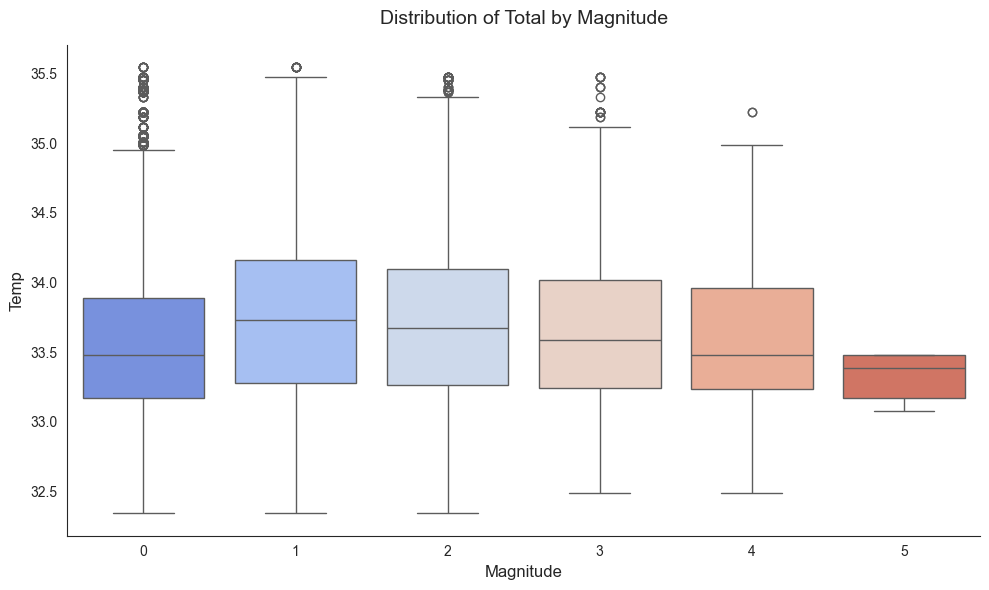

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

tornados_lm_filtered = tornados_lm[(tornados_lm['mag'] != -9) & (tornados_lm['yr'] >= 2000)]

sns.boxplot(
    data=tornados_lm_filtered,
    x='mag',
    y='temp_f',
    palette='coolwarm',
    showfliers=True  # show outliers as dots
)

plt.title('Distribution of Total by Magnitude', fontsize=14, pad=15)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Temp', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


In [292]:
tornados_lm

,om,yr,mo,dy,date_x,time,tz,st,stf,stn,...,f4,fc,mid_month,hemisphere,year,month,date_y,temp,fahrenheit,temp_f
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,0,0,1950-10-15,NH,1950,Oct,1950-10-15,-0.07,31.874,31.874
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,0,0,1950-10-15,NH,1950,Oct,1950-10-15,-0.07,31.874,31.874
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0,0,1950-11-15,NH,1950,Nov,1950-11-15,-0.34,31.388,31.388
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0,0,1950-11-15,NH,1950,Nov,1950-11-15,-0.34,31.388,31.388
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,0,0,1950-11-15,NH,1950,Nov,1950-11-15,-0.34,31.388,31.388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71808,624887,2024,9,7,2024-09-07,05:58:00,3,IN,18,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71811,624890,2024,9,9,2024-09-09,15:15:00,3,NY,36,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844


In [293]:
tornados_lm_filtered

,om,yr,mo,dy,date_x,time,tz,st,stf,stn,...,f4,fc,mid_month,hemisphere,year,month,date_y,temp,fahrenheit,temp_f
40515,1059,2000,10,13,2000-10-13,17:45:00,3,IA,19,44,...,0,0,2000-10-15,NH,2000,Oct,2000-10-15,0.29,32.522,32.522
40516,540,2000,10,20,2000-10-20,17:35:00,3,KS,20,42,...,0,0,2000-10-15,NH,2000,Oct,2000-10-15,0.29,32.522,32.522
40517,561,2000,10,21,2000-10-21,16:41:00,3,OK,40,39,...,0,0,2000-10-15,NH,2000,Oct,2000-10-15,0.29,32.522,32.522
40518,559,2000,10,22,2000-10-22,11:01:00,3,TX,48,119,...,0,0,2000-10-15,NH,2000,Oct,2000-10-15,0.29,32.522,32.522
40519,560,2000,10,22,2000-10-22,11:40:00,3,TX,48,120,...,0,0,2000-10-15,NH,2000,Oct,2000-10-15,0.29,32.522,32.522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71806,624885,2024,9,5,2024-09-05,13:30:00,3,OK,40,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71807,624886,2024,9,6,2024-09-06,19:34:00,3,NY,36,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71809,624888,2024,9,9,2024-09-09,14:19:00,3,WY,56,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844
71810,624889,2024,9,9,2024-09-09,14:33:00,3,NY,36,0,...,0,0,2024-09-15,NH,2024,Sep,2024-09-15,1.58,34.844,34.844


In [294]:
tornados_severe = tornados_lm_filtered[tornados_lm_filtered['mag'] >= 2]

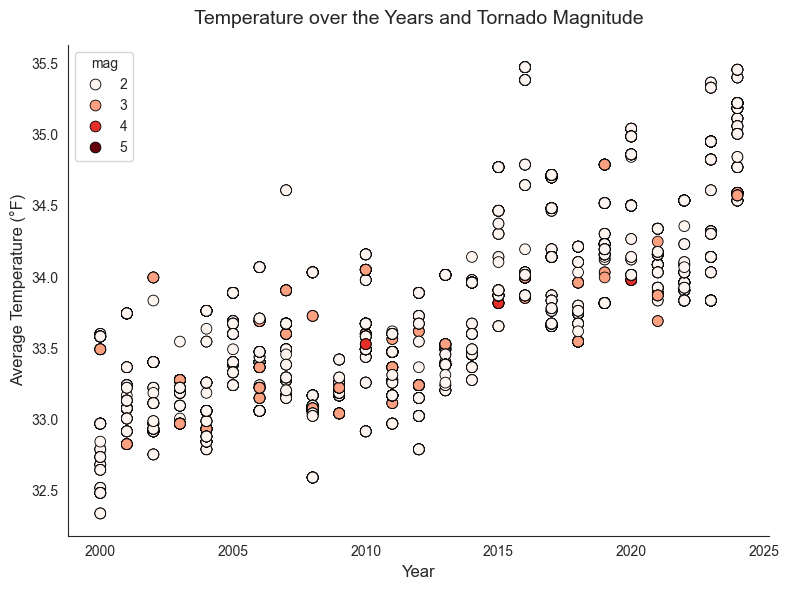

In [295]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=tornados_severe,
    x='year',
    y='temp_f',
    hue='mag',
    s=60,
    color='tab:blue',
    edgecolor='black',
    palette='Reds'
)

plt.title('Temperature over the Years and Tornado Magnitude', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°F)', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

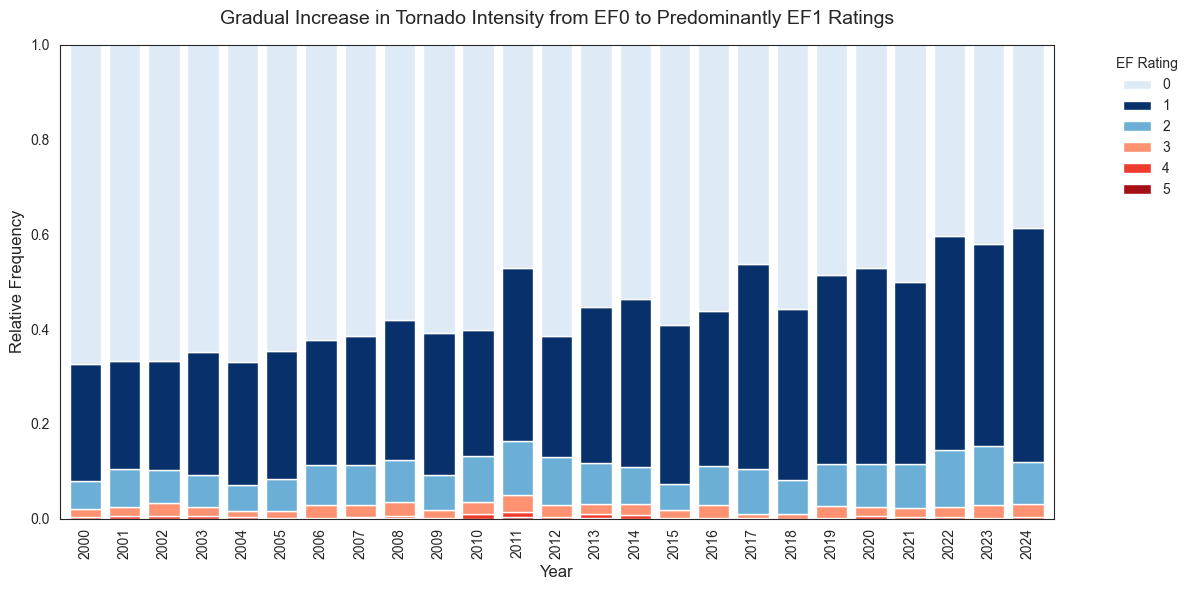

In [300]:
# --- 1. Group by year and magnitude, count tornadoes ---
freq = (
    tornados_lm_filtered
    .groupby(['yr', 'mag'])
    .size()
    .unstack(fill_value=0)
)

# --- 2. Convert to relative frequency (proportion by year) ---
freq = freq.div(freq.sum(axis=1), axis=0)

# --- 3. Reverse stacking order so strong tornadoes (high mag) at bottom ---
freq = freq[sorted(freq.columns, reverse=True)]

# --- 4. Define custom palette (3–5 = reds, 1–2 = blues) ---
palette = {
    5: "#a50f15",  # dark red
    4: "#ef3b2c",  # medium red
    3: "#fc9272",  # light red
    2: "#6baed6",  # light blue
    1: "#08306b",  # dark blue
    0: "#deebf7"   # optional if EF0 or 0 category exists
}

# Ensure only available magnitude columns get colored
available_mags = [c for c in freq.columns if c in palette]
colors = [palette[m] for m in available_mags]

# --- 5. Plot stacked bar chart ---
fig, ax = plt.subplots(figsize=(12, 6))

freq[available_mags].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.8
)

# --- 6. Formatting ---
ax.set_title('Gradual Increase in Tornado Intensity from EF0 to Predominantly EF1 Ratings', fontsize=14, pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency', fontsize=12)
ax.set_ylim(0, 1)
ax.tick_params(axis='x', rotation=90)

# Legend (flipped to 1 → 5 top-to-bottom)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='EF Rating',
          bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


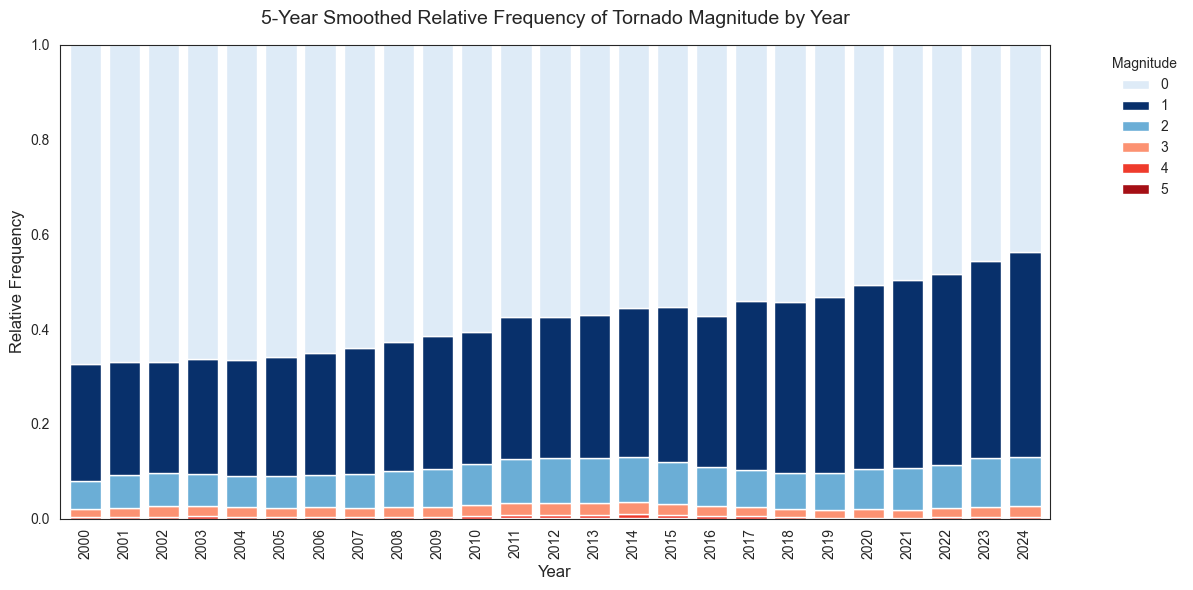

In [ ]:
# --- 1. Group by year and magnitude, count tornadoes ---
freq = (
    tornados_lm_filtered
    .groupby(['yr', 'mag'])
    .size()
    .unstack(fill_value=0)
)

# --- 2. Convert to relative frequency (proportion by year) ---
freq = freq.div(freq.sum(axis=1), axis=0)

# --- 3. Apply 5-year rolling mean smoothing ---
freq_rolling = freq.rolling(window=5, min_periods=1).mean()

# --- 4. Reverse stacking order so strong tornadoes (high mag) at bottom ---
freq_rolling = freq_rolling[sorted(freq_rolling.columns, reverse=True)]

# --- 5. Define custom palette (3–5 = reds, 1–2 = blues) ---
palette = {
    5: "#a50f15",  # dark red
    4: "#ef3b2c",  # medium red
    3: "#fc9272",  # light red
    2: "#6baed6",  # light blue
    1: "#08306b",  # dark blue
    0: "#deebf7"   # optional if EF0 or 0 category exists
}

# Ensure only available magnitude columns get colored
available_mags = [c for c in freq_rolling.columns if c in palette]
colors = [palette[m] for m in available_mags]

# --- 6. Plot stacked bar chart ---
fig, ax = plt.subplots(figsize=(12, 6))

freq_rolling[available_mags].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.8
)

# --- 7. Formatting ---
ax.set_title('5-Year Smoothed Relative Frequency of Tornado Magnitude by Year', fontsize=14, pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Relative Frequency', fontsize=12)
ax.set_ylim(0, 1)
ax.tick_params(axis='x', rotation=90)

# Legend (flipped to 1 → 5 top-to-bottom)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Magnitude',
          bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


| **EF Rating** | **Estimated Wind Speed (mph)** | **Damage Description**                                                              | **Severity** |
| ------------- | ------------------------------ | ----------------------------------------------------------------------------------- | ------------ |
| **EF0**       | 65–85                          | Light damage (shallow-rooted trees uprooted, minor roof damage)                     | Weak         |
| **EF1**       | 86–110                         | Moderate damage (mobile homes overturned, roof surfaces stripped)                   | Weak         |
| **EF2**       | 111–135                        | Considerable damage (roofs torn off well-built homes, large trees snapped/uprooted) | **Severe**   |
| **EF3**       | 136–165                        | Severe damage (entire stories of homes destroyed, trains overturned)                | **Severe**   |
| **EF4**       | 166–200                        | Devastating damage (well-constructed houses leveled)                                | **Violent**  |
| **EF5**       | >200                           | Incredible damage (strong homes swept from foundations, trees debarked)             | **Violent**  |


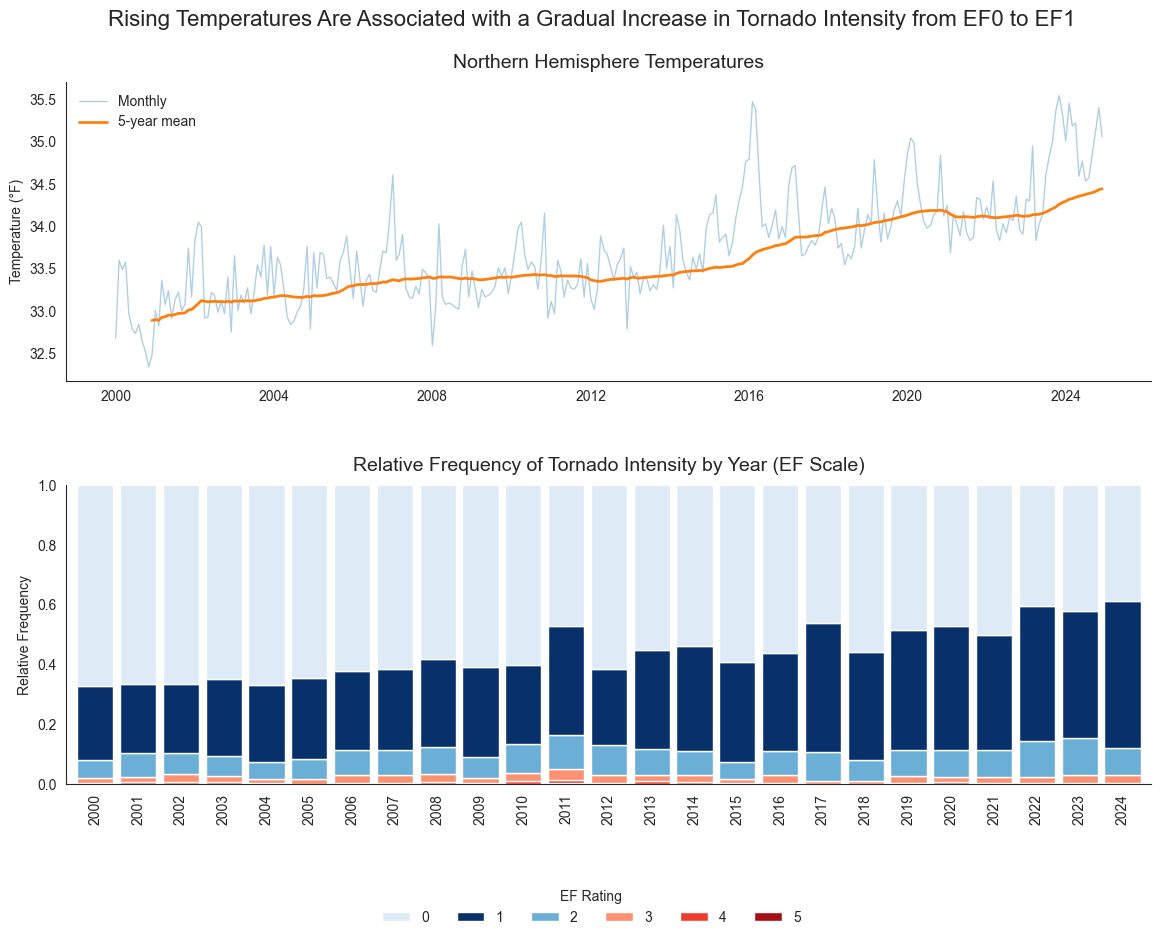

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# A) Temperature – NH only
# =========================
df = temperature_filtered.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Monthly series for NH
monthly = (
    df[df['hemisphere'] == 'NH']
      .set_index('date')['temp_f']
      .resample('MS').mean()
      .reset_index()
)

# 5-year rolling mean (60 months, require at least 12 months)
monthly['temp_f_5yr'] = (
    monthly.set_index('date')['temp_f']
           .rolling(window=60, min_periods=12).mean()
           .reset_index(drop=True)
)

# =========================
# B) Tornado EF distribution
# =========================
freq = (
    tornados_lm_filtered
    .groupby(['yr', 'mag'])
    .size()
    .unstack(fill_value=0)
)

freq = freq.div(freq.sum(axis=1), axis=0)                 # proportions by year
freq = freq[sorted(freq.columns, reverse=True)]           # strong at bottom

palette = {5:"#a50f15", 4:"#ef3b2c", 3:"#fc9272", 2:"#6baed6", 1:"#08306b", 0:"#deebf7"}
available_mags = [c for c in freq.columns if c in palette]
colors = [palette[m] for m in available_mags]

# =========================
# C) Combined figure
# =========================
sns.set_style('white')
fig, (ax_top, ax_bot) = plt.subplots(nrows=2, ncols=1, figsize=(14, 9), sharex=False)

# Top: NH temperature (monthly + 5-year mean)
sns.lineplot(data=monthly, x='date', y='temp_f', ax=ax_top, linewidth=1, alpha=0.35, label='Monthly')
sns.lineplot(data=monthly, x='date', y='temp_f_5yr', ax=ax_top, linewidth=2, label='5-year mean')
ax_top.set_title('Northern Hemisphere Temperatures', fontsize=14, pad=10)
ax_top.set_xlabel('')
ax_top.set_ylabel('Temperature (°F)')
ax_top.legend(frameon=False, loc='upper left')

# Bottom: Tornado EF mix
freq[available_mags].plot(kind='bar', stacked=True, ax=ax_bot, color=colors, width=0.85, legend=False)
ax_bot.set_title('Relative Frequency of Tornado Intensity by Year (EF Scale)', fontsize=14, pad=10)
ax_bot.set_xlabel('')
ax_bot.set_ylabel('Relative Frequency')
ax_bot.set_ylim(0, 1)
ax_bot.tick_params(axis='x', rotation=90)

# Shared legend for EF categories at the bottom
handles, labels = ax_bot.get_legend_handles_labels()
fig.legend(
    handles[::-1],
    [str(l) for l in available_mags[::-1]],
    title='EF Rating',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # pushes legend below the plot
    ncol=len(available_mags),
    frameon=False
)

fig.suptitle('Rising Temperatures Are Associated with a Gradual Increase in Tornado Intensity from EF0 to EF1', fontsize=16, y=0.98)
sns.despine()
plt.subplots_adjust(top=0.90, bottom=0.12, hspace=0.35)  # extra bottom margin for legend
plt.show()

